In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

# Dataset

In [3]:
data = pd.read_csv('/kaggle/input/sunspots/Sunspots.csv')
df = data.tail(60)
df.rename(columns={'Monthly Mean Total Sunspot Number': 'data'}, inplace=True)
df

,Unnamed: 0,Date,data
3192,3192,2015-01-31,93.0
3193,3193,2015-02-28,66.7
3194,3194,2015-03-31,54.5
3195,3195,2015-04-30,75.3
3196,3196,2015-05-31,88.8
3197,3197,2015-06-30,66.5
3198,3198,2015-07-31,65.8
3199,3199,2015-08-31,64.4
3200,3200,2015-09-30,78.6
3201,3201,2015-10-31,63.6


## Visualizing the Dataset

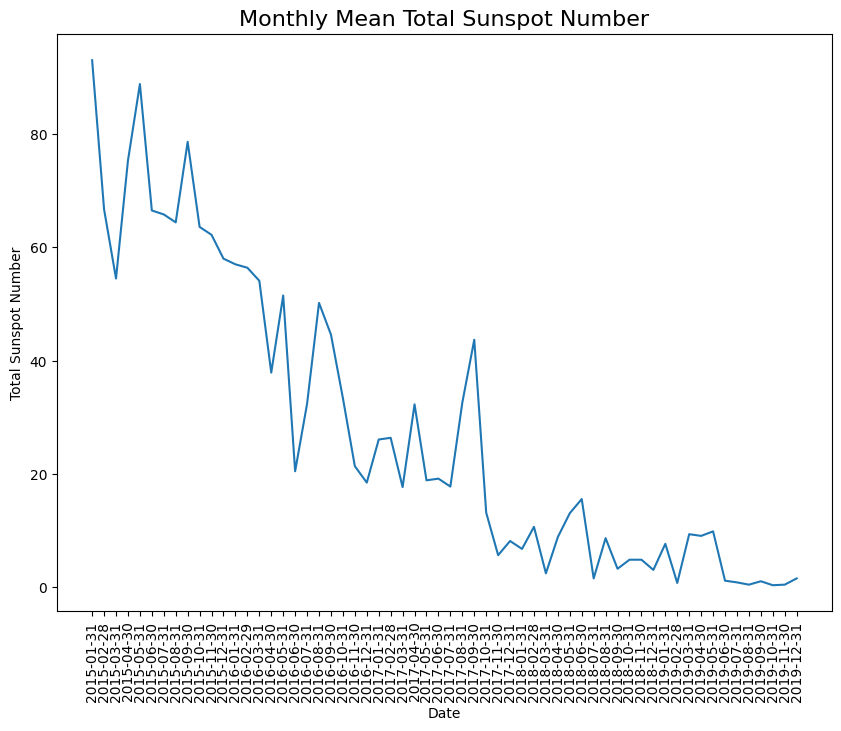

In [4]:
plt.plot(df['Date'], df['data'])
plt.title('Monthly Mean Total Sunspot Number', size = 16)
plt.ylabel('Total Sunspot Number')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

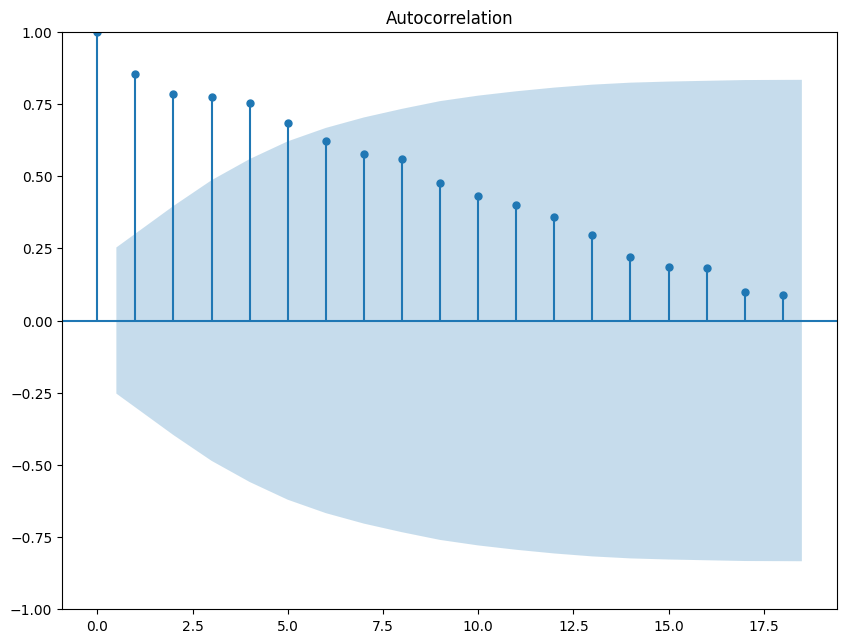

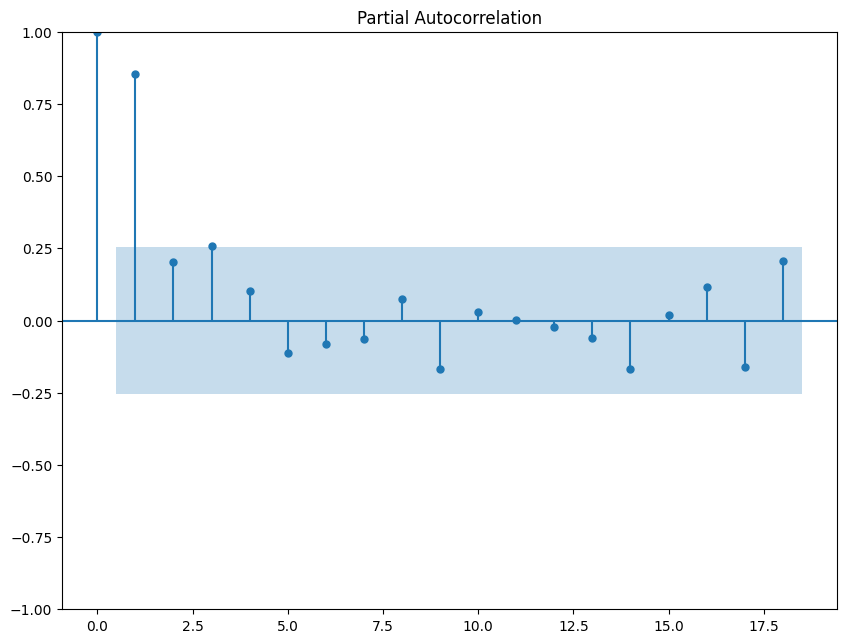

In [5]:
plot_acf(df['data']);
plot_pacf(df['data']);

**Observations:**

>The **acf** shows a ***non-stationary*** characteristic.

>The **pacf** also seems to show a ***non-stationary*** characteristic.

>This suggests a **seasonal data**

In [6]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        endog - the observed variable
    """
    
    #list that will contain the results of every ARIMA model (p,d,q)
    results = []
    
    #tqdm is a timer and progress bar (for any programmer's sanity)
    #this loop will create the 
    for param in tqdm_notebook(parameters_list):
        
        # will create a model based on provided `order_list`
        try: 
            model = SARIMAX(endog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), simple_differencing=False).fit(disp=False)
        
        #will just continue if it encounters an error (a try clause is always paired with except)
        except:
            continue
        
        #calculates the aic value of the model
        aic = model.aic
        
        #appends a list containing the order with its respective aic value
        results.append([param, aic])
    
    #converts the `results` list into a dataframe
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    #returns the summary df containing all the salient information
    return result_df

In [7]:
#p values to test
p = range(0, 11, 1)

#constant differencing value d
d = 1

#q values to test
q = range(0, 11, 1)

#P values to test
P = range(0, 11, 1)

#constant differencing value d
D = 1

#Q values to test
Q = range(0, 11, 1)

# Create a list with all possible combination of parameters
parameters = product(p, q, P, Q) #the product function will create all possible combinations of p and q to evaluate
parameters_list = list(parameters)


#display the first ten values in the order list
print(len(parameters_list))
print(parameters_list[:10])

14641
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 0, 4), (0, 0, 0, 5), (0, 0, 0, 6), (0, 0, 0, 7), (0, 0, 0, 8), (0, 0, 0, 9)]


In [8]:
result_df = optimize_SARIMA(df['data'], parameters_list, d, D, 4)
result_df

  0%|          | 0/14641 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 0, 0, 2)",407.120294
1,"(2, 3, 0, 1)",407.822037
2,"(0, 5, 0, 0)",407.908903
3,"(0, 5, 1, 0)",408.090861
4,"(2, 3, 0, 2)",408.241789
...,...,...
2594,"(3, 0, 0, 0)",445.245094
2595,"(0, 0, 9, 10)",446.276069
2596,"(0, 0, 10, 10)",446.869545
2597,"(2, 2, 10, 10)",447.139387


In [9]:
best_model = SARIMAX(df['data'], order=(3,1,0), seasonal_order=(0,1,2,4), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                   data   No. Observations:                   60
Model:             SARIMAX(3, 1, 0)x(0, 1, [1, 2], 4)   Log Likelihood                -197.560
Date:                                Wed, 27 Dec 2023   AIC                            407.120
Time:                                        00:24:20   BIC                            419.164
Sample:                                             0   HQIC                           411.778
                                                 - 60                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5129      0.128     -4.004      0.000      -0.764      -0.262
ar.

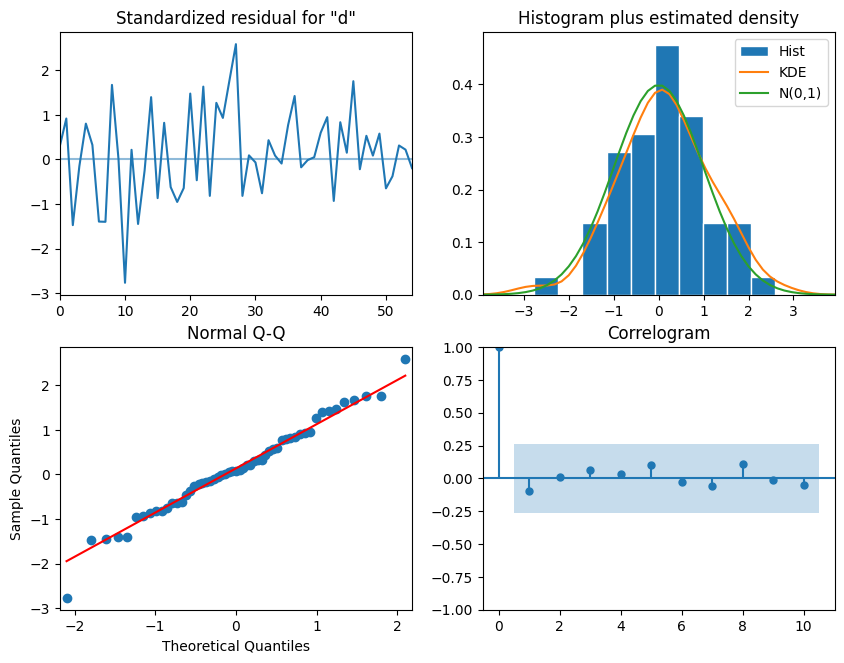

In [10]:
res.plot_diagnostics();

**Observations:**

>The residuals appear to be ***mean-centered residuals***, with most values falling between -2 and 2.

>Histogram shows most points are clustered in the middle presents ***normal distribution***.

>Normal Q-Q plot shows data points are ***close to the best fitting line***

>Correlogram shows ***stationarity***

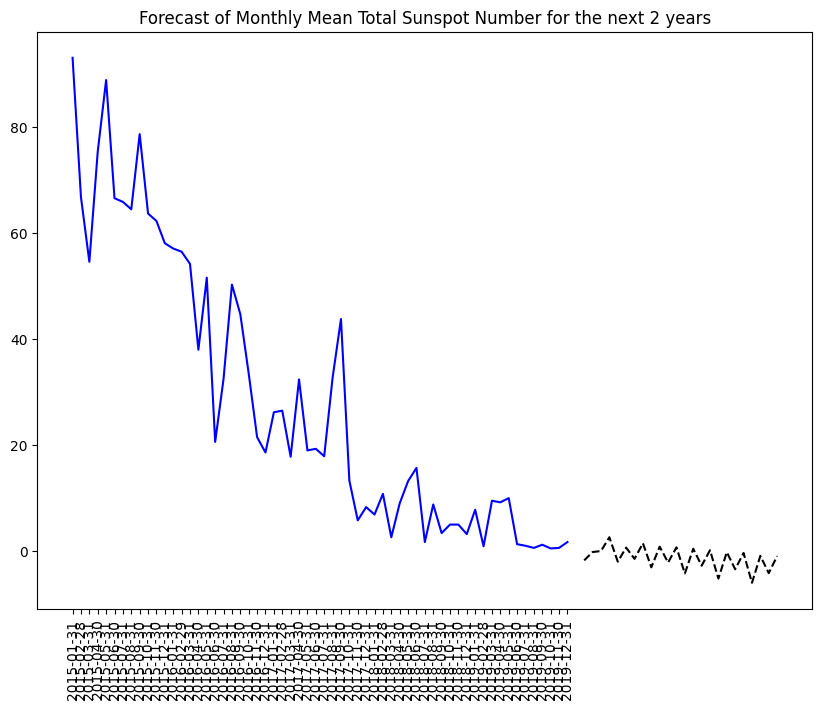

In [11]:
n_forecast = 24 #Lets say we want to forecast 2 years of data (24 months) in the future
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

#visualize the predictions with respect ot historical data (use different markers)
fig, ax = plt.subplots()
ax.plot(df['Date'], df['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Monthly Mean Total Sunspot Number for the next 2 years')
plt.xticks(rotation=90)
plt.show()

In [12]:
df['model'] = predict.predicted_mean
df

,Unnamed: 0,Date,data,model
3192,3192,2015-01-31,93.0,0.000000
3193,3193,2015-02-28,66.7,92.998467
3194,3194,2015-03-31,54.5,66.700276
3195,3195,2015-04-30,75.3,54.499941
3196,3196,2015-05-31,88.8,121.800008
3197,3197,2015-06-30,66.5,62.505323
3198,3198,2015-07-31,65.8,53.580699
3199,3199,2015-08-31,64.4,83.886492
3200,3200,2015-09-30,78.6,80.596243
3201,3201,2015-10-31,63.6,55.316979


In [13]:
from math import sqrt

# mse = mean_squared_error(df['data'], df['model'])
# print(f'MSE: {mse}')
rmse = sqrt(mean_squared_error(df['data'], df['model']))
print(f'RMSE: {rmse}')

RMSE: 16.061530622260292


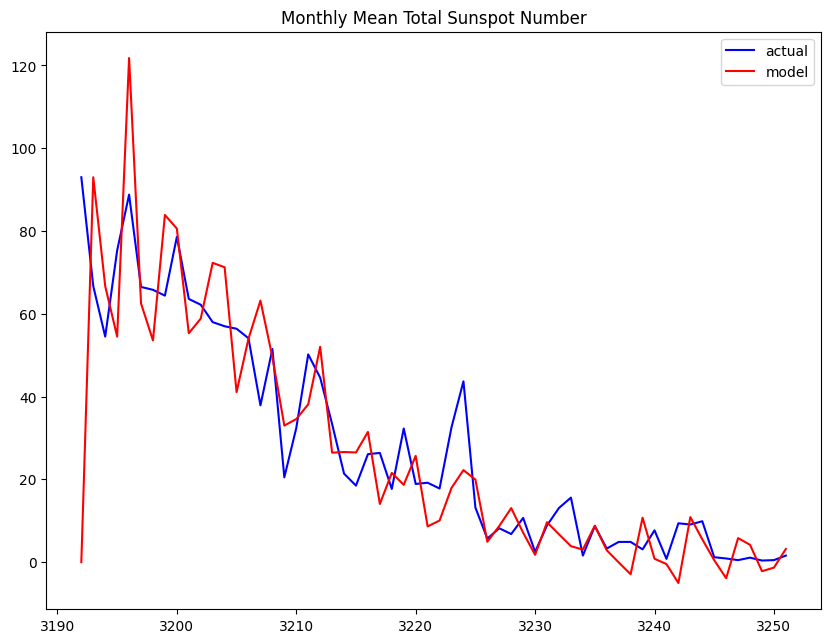

In [14]:
plt.plot(df['data'], color='blue', label='actual')
plt.plot(df['model'], color='red', label='model')
plt.legend(loc='best')
plt.title('Monthly Mean Total Sunspot Number')
plt.show()

**Observations:**

>Despite capturing the downward trend, the model's unable to match the historical/actual data points.